In [17]:
from dataloader import DAVIS_Seq2, normalize_image, BallDataset, Balltest
from model import NeighborModel
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import PIL.Image as Image
import numpy as np
from preprocess_utensils import get_gray_image, get_boundary_iou
import json
from loss import order_loss, chamer_distance_loss
import random

In [18]:
!nvidia-smi

Thu Mar 14 19:54:18 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-PCIE-40GB          On  |   00000000:37:00.0 Off |                    0 |
| N/A   74C    P0            258W /  250W |   31435MiB /  40960MiB |    100%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [19]:
data_set = BallDataset()
# data_set = BallDataset(is_previous=False)
# data_set = BallDataset("ellipse/uniform_samples_80.json")
# data_set = DAVIS_Seq2(is_one_video=True)
# test_set = Balltest("ellipse/uniform_samples_80.json")
test_set = Balltest()

batch_size = 1
data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=True, num_workers=4)

In [20]:
pre_frame, curr_frame, pre_boundary, curr_boundary, pre_idx, curr_idx = next(iter(data_loader))
pre_idx, curr_idx

(tensor([10]), tensor([11]))

In [21]:
pre_frame.shape

torch.Size([1, 3, 224, 224])

Text(0.5, 1.0, 'Curr Frame')

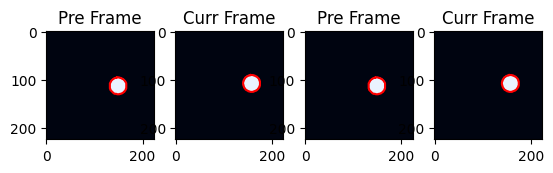

In [22]:
index = 0
plt.subplot(1, 4, 1)
plt.imshow(normalize_image(pre_frame[index].permute(1, 2, 0)))
plt.plot(pre_boundary[index][:, 0], pre_boundary[index][:, 1], 'r')
plt.title('Pre Frame')
plt.subplot(1, 4, 2)
plt.imshow(normalize_image(curr_frame[index].permute(1, 2, 0)))
plt.plot(curr_boundary[index][:, 0], curr_boundary[index][:, 1], 'r')
plt.title('Curr Frame')
plt.subplot(1, 4, 3)
plt.imshow(normalize_image(test_set[pre_idx][0].permute(1, 2, 0)))
plt.plot(pre_boundary[index][:, 0], pre_boundary[index][:, 1], 'r')
plt.title('Pre Frame')
plt.subplot(1, 4, 4)
plt.imshow(normalize_image(test_set[curr_idx][0].permute(1, 2, 0)))
plt.plot(curr_boundary[index][:, 0], curr_boundary[index][:, 1], 'r')
plt.title('Curr Frame')


In [23]:
model = NeighborModel()

/zhome/32/f/202284/CV/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [24]:
torch.cuda.empty_cache()

In [25]:
model = model.cuda()
results = model(pre_frame.to("cuda"), curr_frame.to("cuda"), pre_boundary.to("cuda"))
order_loss(results[-1], curr_boundary.to("cuda"))

tensor(13.8368, device='cuda:0', grad_fn=<DivBackward0>)

In [26]:
model = NeighborModel().to('cuda')
model_name = "uniform_model"
data_set = BallDataset()
# data_set = BallDataset(is_previous=False)
# data_set = BallDataset("ellipse/uniform_samples_80.json")
# data_set = BallDataset("ellipse/uniform_samples_80.json", is_previous=False)
# data_set = DAVIS_Seq2(is_uniform=True, is_one_video=True)
# loss_name = "chamer_distance_loss"
loss_name = "order_loss"
if loss_name == "chamer_distance_loss":
    loss_func = chamer_distance_loss
else:
    loss_func = order_loss
batch_size = 1
data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=True, num_workers=4)

In [28]:
torch.cuda.memory_allocated() / 1024 / 1024 / 1024

4.11332368850708

In [29]:
dict_loss = {}
num_epochs = 100
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
gradient_clip = 2
min_loss = 1e10
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
def lr_lambda(epoch):
    if epoch < 5:
        return 1
    elif epoch < 40:
        return 0.1
    else:
        return 0.01
# scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
for e in range(num_epochs):
    model.train()
    mean_loss = 0
    for pre_frame, curr_frame, pre_boundary, curr_boundary, pre_idx, curr_idx in tqdm(data_loader, position=0, leave=True):
    # for pre_frame, curr_frame, pre_boundary, curr_boundary, pre_idx, curr_idx in data_loader:
        pre_frame, curr_frame, pre_boundary, curr_boundary = (
            pre_frame.to("cuda"),
            curr_frame.to("cuda"),
            pre_boundary.to("cuda"),
            curr_boundary.to("cuda"),
        )
        pre_idx = pre_idx.item()
        curr_idx = curr_idx.item()
        optimizer.zero_grad()
        results = model(pre_frame, curr_frame, pre_boundary)
        refine_num = len(results)
        loss = 0
        for i in range(refine_num):
            loss += 0.8 ** (refine_num - i - 1) * loss_func(results[i], curr_boundary)
        mean_loss += loss.item()
        nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
        loss.backward()
        optimizer.step()
        if loss.item() < min_loss:
            min_loss = loss.item()
            torch.save(model.state_dict(), f"./models/{model_name}_{loss_name}.pth")
    mean_loss /= len(data_loader)
    # tqdm.write(f"Epoch {e + 1}, Loss: {mean_loss}, Poss: {possibility}", end="")
    print(f"Epoch {e + 1}, Loss: {mean_loss:.2f}")
    dict_loss[e] = mean_loss
    # scheduler.step()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [01:28<00:00,  7.40s/it]


Epoch 1, Loss: 33.26


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:59<00:00,  4.93s/it]


Epoch 2, Loss: 23.63


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:42<00:00,  3.57s/it]


Epoch 3, Loss: 22.53


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:59<00:00,  4.92s/it]


Epoch 4, Loss: 22.26


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.31s/it]


Epoch 5, Loss: 22.37


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.27s/it]


Epoch 6, Loss: 22.20


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.29s/it]


Epoch 7, Loss: 21.83


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:44<00:00,  3.68s/it]


Epoch 8, Loss: 22.05


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:49<00:00,  4.10s/it]


Epoch 9, Loss: 21.68


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:49<00:00,  4.09s/it]


Epoch 10, Loss: 21.38


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:43<00:00,  3.65s/it]


Epoch 11, Loss: 20.81


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:58<00:00,  4.91s/it]


Epoch 12, Loss: 19.74


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:44<00:00,  3.72s/it]


Epoch 13, Loss: 19.41


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.27s/it]


Epoch 14, Loss: 19.23


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.30s/it]


Epoch 15, Loss: 20.47


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:50<00:00,  4.22s/it]


Epoch 16, Loss: 19.59


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:47<00:00,  3.97s/it]


Epoch 17, Loss: 18.84


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:38<00:00,  3.21s/it]


Epoch 18, Loss: 18.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:46<00:00,  3.88s/it]


Epoch 19, Loss: 17.06


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.28s/it]


Epoch 20, Loss: 18.60


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:38<00:00,  3.21s/it]


Epoch 21, Loss: 18.20


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:44<00:00,  3.70s/it]


Epoch 22, Loss: 16.95


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:44<00:00,  3.70s/it]


Epoch 23, Loss: 18.41


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.28s/it]


Epoch 24, Loss: 18.64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.27s/it]


Epoch 25, Loss: 18.71


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.26s/it]


Epoch 26, Loss: 17.82


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:44<00:00,  3.73s/it]


Epoch 27, Loss: 16.12


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:43<00:00,  3.66s/it]


Epoch 28, Loss: 16.36


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:49<00:00,  4.10s/it]


Epoch 29, Loss: 17.10


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.28s/it]


Epoch 30, Loss: 17.99


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:49<00:00,  4.10s/it]


Epoch 31, Loss: 16.75


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.28s/it]


Epoch 32, Loss: 17.35


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:34<00:00,  2.86s/it]


Epoch 33, Loss: 18.54


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.26s/it]


Epoch 34, Loss: 20.13


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.29s/it]


Epoch 35, Loss: 16.93


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.26s/it]


Epoch 36, Loss: 16.30


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.29s/it]


Epoch 37, Loss: 16.60


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.26s/it]


Epoch 38, Loss: 15.95


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:44<00:00,  3.69s/it]


Epoch 39, Loss: 15.10


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:48<00:00,  4.02s/it]


Epoch 40, Loss: 13.89


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.29s/it]


Epoch 41, Loss: 13.58


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.29s/it]


Epoch 42, Loss: 14.76


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:43<00:00,  3.67s/it]


Epoch 43, Loss: 13.57


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.28s/it]


Epoch 44, Loss: 13.28


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.27s/it]


Epoch 45, Loss: 13.31


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:49<00:00,  4.09s/it]


Epoch 46, Loss: 12.75


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.29s/it]


Epoch 47, Loss: 13.50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:33<00:00,  2.82s/it]


Epoch 48, Loss: 12.58


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.29s/it]


Epoch 49, Loss: 12.75


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.27s/it]


Epoch 50, Loss: 12.41


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.29s/it]


Epoch 51, Loss: 13.16


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:44<00:00,  3.68s/it]


Epoch 52, Loss: 12.47


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.29s/it]


Epoch 53, Loss: 12.68


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.26s/it]


Epoch 54, Loss: 11.79


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.30s/it]


Epoch 55, Loss: 12.75


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:34<00:00,  2.88s/it]


Epoch 56, Loss: 12.17


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.29s/it]


Epoch 57, Loss: 11.22


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.27s/it]


Epoch 58, Loss: 11.73


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.28s/it]


Epoch 59, Loss: 11.29


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.28s/it]


Epoch 60, Loss: 12.47


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:37<00:00,  3.16s/it]


Epoch 61, Loss: 13.31


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.28s/it]


Epoch 62, Loss: 15.32


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.29s/it]


Epoch 63, Loss: 15.47


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:33<00:00,  2.83s/it]


Epoch 64, Loss: 13.54


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.26s/it]


Epoch 65, Loss: 16.30


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.28s/it]


Epoch 66, Loss: 15.41


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.27s/it]


Epoch 67, Loss: 14.34


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.28s/it]


Epoch 68, Loss: 13.21


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.27s/it]


Epoch 69, Loss: 13.35


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:44<00:00,  3.68s/it]


Epoch 70, Loss: 12.69


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.27s/it]


Epoch 71, Loss: 14.11


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:33<00:00,  2.82s/it]


Epoch 72, Loss: 13.51


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.27s/it]


Epoch 73, Loss: 14.74


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.29s/it]


Epoch 74, Loss: 14.90


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.27s/it]


Epoch 75, Loss: 13.55


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.30s/it]


Epoch 76, Loss: 12.24


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:44<00:00,  3.68s/it]


Epoch 77, Loss: 13.11


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:49<00:00,  4.10s/it]


Epoch 78, Loss: 12.45


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:40<00:00,  3.34s/it]


Epoch 79, Loss: 12.25


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:44<00:00,  3.71s/it]


Epoch 80, Loss: 11.12


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.26s/it]


Epoch 81, Loss: 11.38


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.26s/it]


Epoch 82, Loss: 11.98


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.27s/it]


Epoch 83, Loss: 12.72


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.29s/it]


Epoch 84, Loss: 10.66


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.26s/it]


Epoch 85, Loss: 14.94


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.29s/it]


Epoch 86, Loss: 25.02


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:35<00:00,  2.94s/it]


Epoch 87, Loss: 15.85


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.28s/it]


Epoch 88, Loss: 14.41


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.26s/it]


Epoch 89, Loss: 11.57


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.29s/it]


Epoch 90, Loss: 11.83


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.27s/it]


Epoch 91, Loss: 18.34


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.27s/it]


Epoch 92, Loss: 17.58


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.29s/it]


Epoch 93, Loss: 17.24


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.27s/it]


Epoch 94, Loss: 16.88


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:34<00:00,  2.85s/it]


Epoch 95, Loss: 15.29


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.29s/it]


Epoch 96, Loss: 13.67


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.27s/it]


Epoch 97, Loss: 13.10


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.26s/it]


Epoch 98, Loss: 12.86


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.29s/it]


Epoch 99, Loss: 12.63


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:39<00:00,  3.30s/it]

Epoch 100, Loss: 12.74


In [40]:
# save loss
with open(f"./log/{model_name}_{loss_name}.json", "w") as f:
    json.dump(dict_loss, f)

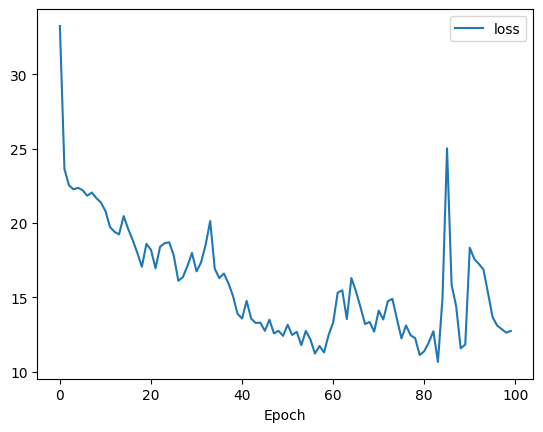

In [30]:
# plot the loss
plt.plot(list(dict_loss.keys()), list(dict_loss.values()), label="loss")
# plt.plot(list(poss_dict.keys()), list(poss_dict.values()), label="possibility")
plt.xlabel("Epoch")
# plt.ylabel("Loss")
plt.legend()

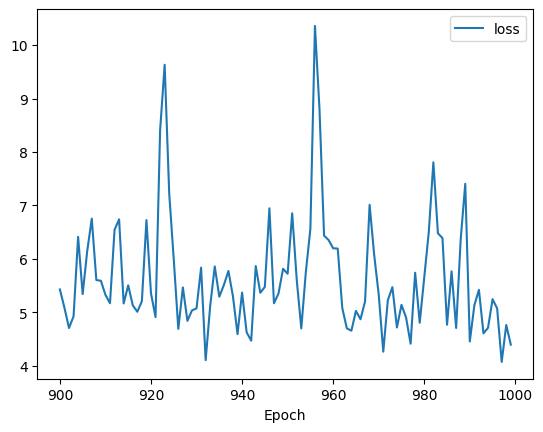

In [18]:
# plot the loss
plt.plot(list(dict_loss.keys())[-100:], list(dict_loss.values())[-100:], label="loss")
# plt.plot(list(poss_dict.keys())[-100:], list(poss_dict.values())[-100:], label="possibility")
plt.xlabel("Epoch")
# plt.ylabel("Loss")
plt.legend()

In [3]:
model = NeighborModel()
model_name = "uniform_model"
# model_name = "simplify_model"
loss_name = "order_loss"
# loss_name = "chamer_distance_loss"
model.load_state_dict(torch.load(f"./models/{model_name}_{loss_name}.pth"))
# model = model.to("cuda")

/zhome/32/f/202284/CV/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


<All keys matched successfully>

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:32<00:00,  2.95s/it]


0.5212496503285589

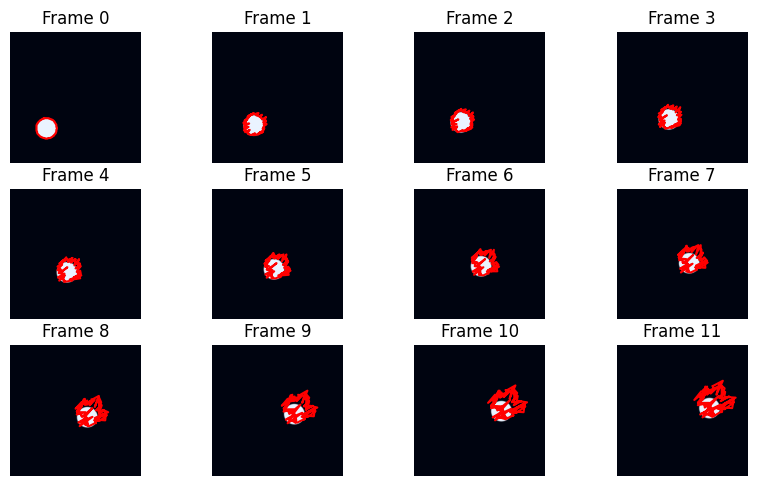

In [31]:
def test_model_one_video(model, test_dataset: torch.utils.data.Dataset, device="cuda"):
    pre_img, pre_sgm, pre_boundary = test_dataset[0]
    plt.figure(figsize=(10, 20))
    plt.subplot(10, 4, 1)
    plt.imshow(normalize_image(pre_img.permute(1, 2, 0)))
    plt.plot(pre_boundary[:, 0], pre_boundary[:, 1], 'r')
    plt.axis('off')
    plt.title('Frame 0')
    pre_boundary = pre_boundary.to(device)
    total_iou = 0
    model.eval()
    interval = 1
    for i in tqdm(range(1, len(test_dataset))):
        img, sgm, boundary = test_dataset[i]
        with torch.no_grad():
            results = model(
                pre_img.unsqueeze(0).to(device),
                img.unsqueeze(0).to(device),
                pre_boundary.unsqueeze(0).to(device),
            )
            pre_boundary = results[-1].squeeze(0).long()
            pre_img = img
            if i % interval == 0:
                plt.subplot(10, 4, i // interval + 1)
                # plt.subplot(4, 4, i // interval)
                plt.imshow(normalize_image(pre_img.permute(1, 2, 0)))
                # index = 10
                # plt.scatter(pre_boundary.cpu().numpy()[:, 0][index], pre_boundary.cpu().numpy()[:, 1][index], )
                plt.plot(pre_boundary.cpu().numpy()[:, 0], pre_boundary.cpu().numpy()[:, 1], "r")
                plt.axis('off')
                plt.title(f'Frame {i}')
        total_iou += get_boundary_iou(sgm, pre_boundary.cpu().numpy())
    return total_iou / (len(test_dataset) - 1)
# if model_name == "uniform_model":
#     test_dataset = DAVIS_test("bear", is_uniform=True)
# else:
#     test_dataset = DAVIS_test("bear", is_uniform=False)
test_dataset = Balltest()
# test_dataset = Balltest("ellipse/uniform_samples_80.json")

test_model_one_video(model, test_dataset,)